## Simulación

In [257]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
random.seed(42)

## Armado de matrices

In [258]:
df_complete = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter =';')

In [259]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Downloads/'
    team_data_path = os.path.join(base_path, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.sort_values(by='Starting_XI', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        return None
    except Exception as e:
        return None

In [260]:
def get_team_players(team):
    base_path = '/Users/luisalawson/Downloads/'
    team_data_path = os.path.join(base_path, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.sort_values(by='Starting_XI', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [261]:
teams_list = ['Manchester United', 'Manchester City', 'Chelsea', 'Arsenal',
       'Tottenham Hotspur', 'Everton', 'Liverpool',
       'West Bromwich Albion', 'Swansea City', 'West Ham United',
       'Norwich City', 'Fulham', 'Stoke City', 'Southampton',
       'Aston Villa', 'Newcastle United', 'Sunderland', 'Wigan Athletic',
       'Reading', 'Queens Park Rangers']

In [262]:
players_dict = defaultdict(list)

for team in teams_list:
    players = get_team_players(team)
    if players:  
        players_dict[team] = players

In [263]:
goalkeepers = df_complete[df_complete['playerPosition'] == 'Goalkeeper']['playerName'].unique()

In [264]:
def player_time(player, team, df):
    player_name  =  player
    matches = df[(df['home_team_name'] == team) | (df['away_team_name'] == team)]
    unique_matches = matches['match_id'].unique()
    total_time = 0
    for match in unique_matches:
        match_df = matches[matches['match_id'] == match]
        players = match_df['playerName'].unique()
        if player_name not in players:
            continue
        match_start = 0
        match_end = match_df['min'].max()
        player_start = match_start
        player_end = match_end
        for index, row in match_df.iterrows():
            if row['description'] == 'Player on' and row['playerName'] == player_name:
                player_start = row['min']
            elif row['description'] == 'Player off' and row['playerName'] == player_name:
                player_end = row['min']
        total_time += (player_end - player_start)
    return total_time

In [265]:
def get_zone(x, y, num_zones=10):
    zone_x = min(x // 10, num_zones - 1)
    zone_y = min(y // 10, num_zones - 1)
    return zone_x, zone_y

In [266]:
def build_goalkeeper_matrix(player, team, df):
    matches = df[(df['home_team_name'] == team) | (df['away_team_name'] == team)]
    matches_df = matches.reset_index(drop=True)
    save_matrix = np.zeros((10, 10))
    attempt_matrix = np.zeros((10, 10))
    goal_matrix = np.zeros((10, 10))
    for i, row in matches_df.iterrows():
        event_type = row['description']
        outcome = row['outcome']
        x = round(float(row['x'].replace(',', '.')))
        y = round(float(row['y'].replace(',', '.')))
        if 0 <= x < 100 and 0 <= y < 100:
            zone_x, zone_y = get_zone(x, y)
            if event_type == 'Attempt Saved':
                if i > 0:
                    prev_row = matches_df.loc[i - 1]
                    if (prev_row['description'] == 'Save' and 
                        prev_row['playerName'] == player):
                        save_matrix[zone_x, zone_y] += 1
                        attempt_matrix[zone_x, zone_y] += 1
                if i < len(matches_df) - 1:
                    next_row = matches_df.loc[i + 1]
                    if (next_row['description'] == 'Save' and 
                        next_row['playerName'] == player):  
                        save_matrix[zone_x, zone_y] += 1
                        attempt_matrix[zone_x, zone_y] += 1
            elif event_type == 'Goal' and outcome == 1:
                goal_matrix[zone_x, zone_y] += 1
                attempt_matrix[zone_x, zone_y] += 1

    probability_matrix = np.zeros((10, 10))
    
    for x in range(10):
        for y in range(10):
            total_attempts = attempt_matrix[x, y]
            if total_attempts > 0:  
                probability_matrix[x, y] = save_matrix[x, y] / total_attempts
    probability_matrix = pd.DataFrame(probability_matrix)
    return probability_matrix


In [267]:
def update_player_matrices(player, team, df, goalkeepers):
    time_played = player_time(player, team, df)
    shot_matrix = np.zeros((10, 10))  
    shot_on_goal_matrix = np.zeros((10, 10))  
    goal_matrix = np.zeros((10,10))
    pass_matrix = np.zeros((10, 10)) 
    errors_matrix = np.zeros((10, 10)) 
    defense_matrix = np.zeros((10, 10))
    out_balls = np.zeros((10,10))
    goalkeeper_matrix = np.zeros((10,10))
    matches = (df[(df['home_team_name'] == team) | (df['away_team_name'] == team)]).reset_index(drop=True)
    if player in goalkeepers:
        goalkeeper_matrix = build_goalkeeper_matrix(player, team, df)
    for i, row in matches.iterrows():
        if row['playerName'] == player:
            event_type = row['description']
            event_outcome = row['outcome']
            x = round(float(row['x'].replace(',', '.')))
            y = round(float(row['y'].replace(',', '.')))
            if 0 <= x < 100 and 0 <= y < 100:
                zone_x, zone_y = get_zone(x, y)
                if event_type in ['Miss', 'Post']:
                    shot_matrix[zone_x, zone_y] += 1
                elif event_type == 'Goal' or event_type == 'Attempt Saved':
                    shot_on_goal_matrix[zone_x, zone_y] += 1
                    if event_type == 'Goal':
                        goal_matrix[zone_x, zone_y]+=1
                elif event_type == 'Pass' and event_outcome == 1:
                    pass_matrix[zone_x, zone_y] += 1
                elif event_type == 'Error' and event_outcome == 1:
                    errors_matrix[zone_x, zone_y] += 1
                elif event_type in ['Interception', 'Tackle', 'Clearance', 'Aerial', 'Ball recovery',  'Offside provoked','Shield ball opp' ] and event_outcome==1:
                    defense_matrix[zone_x, zone_y] += 1
            else:
                if event_type == 'Out' and event_outcome == 0:
                    previous_event = df.iloc[i-1]
                    if previous_event['description'] != 'Out':
                        x = round(float(previous_event['x'].replace(',', '.')))
                        y = round(float(previous_event['y'].replace(',', '.')))
                    else:
                        previous_event = df.iloc[i-2]
                        x = round(float(previous_event['x'].replace(',', '.')))
                        y = round(float(previous_event['y'].replace(',', '.')))
                    zone_x, zone_y = get_zone(x, y)
                    out_balls[zone_x,zone_y] += 1
    
    shot_matrix /= time_played
    shot_on_goal_matrix /= time_played
    pass_matrix /= time_played
    goal_matrix /= time_played
    defense_matrix /= time_played
    out_balls /= time_played
    
    return shot_matrix, shot_on_goal_matrix, goal_matrix, pass_matrix, defense_matrix, out_balls, goalkeeper_matrix

In [268]:
def build_pass_direction_matrix(player, team, df):
    pass_direction_matrix = np.zeros((10, 10, 10, 10))
    matches = df[(df['home_team_name'] == team) | (df['away_team_name'] == team)]
    player_matches = matches[matches['playerName'] == player].reset_index(drop=True)
    for i, row in player_matches.iterrows():
        event_type = row['description']
        outcome = row['outcome']
        if event_type == 'Pass' and outcome == 1:
            x_start = round(float(row['x'].replace(',', '.')))
            y_start = round(float(row['y'].replace(',', '.')))
            if i + 1 < len(player_matches):
                next_row = player_matches.iloc[i + 1]
                x_end = round(float(next_row['x'].replace(',', '.')))
                y_end = round(float(next_row['y'].replace(',', '.')))
            else:
                continue
            start_zone_x, start_zone_y = get_zone(x_start, y_start, 10)
            end_zone_x, end_zone_y = get_zone(x_end, y_end, 10)
            pass_direction_matrix[start_zone_x, start_zone_y, end_zone_x, end_zone_y] += 1
    for zone_x_start in range(10):
        for zone_y_start in range(10):
            total_passes_from_zone = np.sum(pass_direction_matrix[zone_x_start, zone_y_start])
            if total_passes_from_zone > 0:
                pass_direction_matrix[zone_x_start, zone_y_start] /= total_passes_from_zone
            else:
                pass
    return pass_direction_matrix

In [ ]:
base_path = '/Users/luisalawson/Desktop/Finaldata'

for team, players in players_dict.items():
    team_path = os.path.join(base_path, team)
    os.makedirs(team_path, exist_ok=True)  
    for player in players:
        print(f'Matrices de {player} construyendose')
        player_path = os.path.join(team_path, player)
        os.makedirs(player_path, exist_ok=True)  
        shot_off_goal_matrix, shot_on_goal_matrix, goal_matrix, pass_matrix, defense_matrix, out_balls, goalkeeper_matrix = update_player_matrices(player, team, df_complete, goalkeepers)
        np.savetxt(os.path.join(player_path, 'shot_off_goal_matrix.csv'), shot_off_goal_matrix, delimiter=',')
        np.savetxt(os.path.join(player_path, 'shot_on_goal_matrix.csv'), shot_on_goal_matrix, delimiter=',')
        np.savetxt(os.path.join(player_path, 'goal_matrix.csv'), goal_matrix, delimiter=',')
        np.savetxt(os.path.join(player_path, 'pass_matrix.csv'), pass_matrix, delimiter=',')
        np.savetxt(os.path.join(player_path, 'defense_matrix.csv'), defense_matrix, delimiter=',')
        np.savetxt(os.path.join(player_path, 'out_balls.csv'), out_balls, delimiter=',')
        np.savetxt(os.path.join(player_path, 'goalkeeper_matrix.csv'), goalkeeper_matrix, delimiter=',')

        pass_direction_matrix = build_pass_direction_matrix(player, team, df_complete)

        np.save(os.path.join(player_path, 'pass_direction_matrix.npy'), pass_direction_matrix)
        print(f'Matrices de {player} terminadas')

## Simulación

In [ ]:
class MatchSimulation:
    def __init__(self, home_players_dict, away_players_dict,home_team = 'Custom Home Team', away_team='Custom Away Team'):
        self.home_team = home_team
        self.away_team = away_team

        self.home_players = home_players_dict
        self.away_players = away_players_dict
        
        self.match_duration = random.randint(100,110)
        
        self.base_path = '/Users/luisalawson/Downloads/data 2'
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.interceptions = {'home': 0, 'away': 0}
        self.passes = {'home': 0, 'away': 0}
        self.shots = {'home': 0, 'away': 0}

        self.home_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))
            
        }
        self.away_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))  
        }

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.flip(matrix, axis=(0, 1))

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """Buscamos las matrices individuales (para armar al equipo)"""
        if matrix_name != 'pass_transition_matrix':
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.csv')
            matrix = np.loadtxt(matrix_path, delimiter=',')
        else:
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
            matrix = np.load(matrix_path)
        return matrix
    
    def mirror_pass_transition_matrix(self,matrix):
        mirrored_matrix = np.flip(matrix, axis=(1, 3))
        mirrored_matrix = np.flip(mirrored_matrix, axis=(0, 2))
        
        return mirrored_matrix
    def aggregate_team_matrices(self, team):
        """Sumamos las matrices para el equipo especificado"""
        if team == 'home':
            for team_name, players in self.home_players.items():
                for player_name, _ in players:  
                    self.home_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.home_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.home_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.home_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.home_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.home_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.home_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix') 
                    self.home_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 
            
            self.home_team_matrixes['goalkeeper_matrix'] = self.mirror_matrix(self.home_team_matrixes['goalkeeper_matrix'])
           
        elif team == 'away':
            for team_name, players in self.away_players.items():
                for player_name, _ in players:  
                    self.away_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.away_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.away_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.away_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.away_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.away_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.away_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  
                    self.away_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 
            
            self.away_team_matrixes['pass_transition_matrix'] = self.mirror_pass_transition_matrix(self.away_team_matrixes['pass_transition_matrix'])
            self.away_team_matrixes['pass_matrix'] = self.mirror_matrix(self.away_team_matrixes['pass_matrix'])
            self.away_team_matrixes['shot_matrix'] = self.mirror_matrix(self.away_team_matrixes['shot_matrix'])
            self.away_team_matrixes['defense_matrix'] = self.mirror_matrix(self.away_team_matrixes['defense_matrix'])
            self.away_team_matrixes['goal_matrix'] = self.mirror_matrix(self.away_team_matrixes['goal_matrix'])
            self.away_team_matrixes['error_matrix'] = self.mirror_matrix(self.away_team_matrixes['error_matrix'])
            self.away_team_matrixes['out_matrix'] = self.mirror_matrix(self.away_team_matrixes['out_matrix'])
           
        else:
            print(f'Error con el equipo: {team}')


    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""
        self.aggregate_team_matrices('home')
        self.aggregate_team_matrices('away')
        
    def select_event(self, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""
        if self.current_team =='home':
            pass_probabilities = self.home_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)

            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.home_team_matrixes['pass_matrix'][current_x, current_y] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.away_team_matrixes['defense_matrix'][current_x, current_y]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y] 
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            goal_probability_ = self.home_team_matrixes['goal_matrix'][current_x, current_y]
            goal_probability = goal_probability_ if not np.isnan(goal_probability_) else 0
            shot_probability_ = (self.home_team_matrixes['shot_matrix'][current_x, current_y]) 
            shot_probability = shot_probability_ if not np.isnan(shot_probability_)  else 0
            out_probability_ = self.home_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0
        
            total_prob = pass_probability + defense_probability + error_probability + shot_probability  + out_probability + goal_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob,
                                out_probability / total_prob,
                                goal_probability/total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot', 'out', 'goal']

            selected_event = np.random.choice(events, p=normalized_probs)

        else:
            pass_probabilities = self.away_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)
            
            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.away_team_matrixes['pass_matrix'][current_x, current_y] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.home_team_matrixes['defense_matrix'][current_x, current_y]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y] 
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            goal_probability_ = self.away_team_matrixes['goal_matrix'][current_x, current_y]
            goal_probability = goal_probability_ if not np.isnan(goal_probability_) else 0
            shot_probability_ = (self.away_team_matrixes['shot_matrix'][current_x, current_y]) 
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.away_team_matrixes['out_matrix'][current_x, current_y] 
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0
            
           
            total_prob = pass_probability + defense_probability + error_probability + shot_probability  + out_probability + goal_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob,
                                out_probability / total_prob,
                                goal_probability/total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot', 'out', 'goal']
            selected_event = np.random.choice(events, p=normalized_probs)

        return selected_event, next_position,self.current_team

    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def restart_from_middle(self):
        self.ball_position =[5,5]

    def step(self):
        events_per_minute = random.randint(8,12)
        for _ in range(events_per_minute):
            current_position = tuple(self.ball_position)
            current_x, current_y = current_position
            current_event, next_position, team = self.select_event(current_x, current_y)

            if current_event == 'pass':
                self.passes[team] += 1
                self.ball_position = next_position

            elif current_event == 'error':
                self.ball_position = current_position
                self.change_possession()

            elif current_event == 'interception':
                self.ball_position = current_position
                if team == 'home':
                    self.interceptions['away'] += 1
                else:
                    self.interceptions['home'] += 1
                self.change_possession()

            elif current_event == 'shot':
                self.shots[team] += 1
                self.change_possession()
                self.restart_from_sideline(current_position)
            
            elif current_event=='goal':
                goal_scored = self.shoot_ball_new(current_x, current_y)
                self.shots[team] += 1
                if goal_scored:
                    self.score[team] += 1
                    self.change_possession()
                    self.restart_from_middle()
                else:
                    self.change_possession()

            elif current_event == 'out':
                self.change_possession()
                self.restart_from_sideline(current_position)

        self.mins_played += 1

    def restart_from_sideline(self, out_position):
        x, y = out_position
        if x <= 4: 
            new_x = 0
        else:  
            new_x = 9
        if y <= 4:  
            new_y = 0
        else:  
            new_y = 9
        self.ball_position = [new_x, new_y]

    def shoot_ball_new(self, current_x, current_y):
        if self.current_team == 'home':
            if self.ball_position[0] < 5:
                return False
            save_prob_home_ = (self.away_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
            save_prob_home = save_prob_home_ if not np.isnan(save_prob_home_) else 0
            
            goal_prob_ = (self.home_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
            goal_prob_total_ = np.sum(self.home_team_matrixes['goal_matrix'] * self.match_duration)
            goal_prob_total = goal_prob_total_ if goal_prob_total_>=1 else 1 
            goal_final = goal_prob_/goal_prob_total

            goal_prob = goal_final*(1-save_prob_home)
            save_prov = (1-goal_final)*save_prob_home

            total_prob = goal_prob + save_prov

            normalized_probs = [goal_prob/total_prob, save_prov/total_prob] 
            events = ['goal', 'save']
            selected_event = np.random.choice(events, p=normalized_probs)
            if selected_event == 'goal':
                return True
            else:
                return False
        else:
            if self.ball_position[0] > 5:
                return False
            
            goal_prob_ = (self.away_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
            goal_prob_total_ = np.sum(self.away_team_matrixes['goal_matrix'] * self.match_duration)
            goal_prob_total = goal_prob_total_ if goal_prob_total_>=1 else 1 
            goal_final = goal_prob_/goal_prob_total

            save_prob_away_ = (self.home_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
            save_prob_away = save_prob_away_ if not np.isnan(save_prob_away_) else 0

            goal_prob = goal_final*(1-save_prob_away)
            save_prov = (1-goal_final)*save_prob_away

            total_prob = goal_prob + save_prov

            normalized_probs = [goal_prob/total_prob, save_prov/total_prob] 
            events = ['goal', 'save']
            selected_event = np.random.choice(events, p=normalized_probs)
            if selected_event == 'goal':
                return True
            else:
                return False
            
    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            self.step()
        
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.shots['home'],
            'tiros_visitante': self.shots['away'],
            'pases_local': self.passes['home'],
            'pases_visitante': self.passes['away'],
            'quites_local': self.interceptions['home'],
            'quites_visitante': self.interceptions['away']
        }

## Manchester United vs Chelsea

Seteamos los equipos y sus planteles (los sacamos en base al 11 titular mas elegido en la temporada)

In [ ]:
def choose_teams(teams_list, players_data):
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1
    

            if 0 <= team_index < len(teams_list):
                team_name = teams_list[team_index]
                available_players = [player for player in players_data[team_name] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_name}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        
                        break
                    elif 0 <= player_index < len(available_players):
                        players_dict[team_name].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a tu equipo.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        available_players.pop(player_index)

                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return players_dict

## Completo

In [9]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [10]:
from itertools import combinations
import pandas as pd

def simulate_all_matches(teams_list, players_data):

    matches = list(combinations(teams_list, 2))  
    results = []  
    all_matches_df = pd.DataFrame()  

    initial_11_dict = {team: get_initial_11(team) for team in teams_list}

    for team, initial_11 in initial_11_dict.items():
        print(f"Jugadores iniciales de {team}: {initial_11}")

    for team1, team2 in matches:
        team1_players = {team1: [(player, 'full_period') for player in initial_11_dict[team1]]}
        team2_players = {team2: [(player, 'full_period') for player in initial_11_dict[team2]]}
        
        print(f"\nSimulando partido entre {team1} y {team2}...")

        match_result_df = simulate_matches(1500, team1_players, team2_players)
        
        match_result_df['winner'] = match_result_df.apply(
            lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                        row['away'] if row['goles_local'] < row['goles_visitante'] else
                        'tie', axis=1
        )

        match_result_df['match'] = f'{team1} vs {team2}'

        all_matches_df = pd.concat([all_matches_df, match_result_df], ignore_index=True)

        total_games = match_result_df.shape[0]
        win_counts = match_result_df['winner'].value_counts()
        win_pct_team1 = (win_counts.get(team1, 0) / total_games) * 100
        win_pct_team2 = (win_counts.get(team2, 0) / total_games) * 100
        tie_pct = (win_counts.get('tie', 0) / total_games) * 100
        loss_pct_team1 = win_pct_team2  
        loss_pct_team2 = win_pct_team1

        new_index = ['win%', 'loss%', 'tie%', 'avg_goles', 'avg_tiros', 'avg_pases', 'avg_quites'] 
        teams_current = [team1, team2]
        df_transposed = pd.DataFrame(index=new_index, columns=teams_current)
        
        df_transposed.loc['win%', team1] = win_pct_team1
        df_transposed.loc['loss%', team1] = loss_pct_team1
        df_transposed.loc['tie%', team1] = tie_pct
        df_transposed.loc['win%', team2] = win_pct_team2
        df_transposed.loc['loss%', team2] = loss_pct_team2
        df_transposed.loc['tie%', team2] = tie_pct

        df_transposed.loc['avg_goles', team1] = match_result_df['goles_local'].mean()
        df_transposed.loc['avg_goles', team2] = match_result_df['goles_visitante'].mean()
        df_transposed.loc['avg_tiros', team1] = match_result_df['tiros_local'].mean()
        df_transposed.loc['avg_tiros', team2] = match_result_df['tiros_visitante'].mean()
        df_transposed.loc['avg_pases', team1] = match_result_df['pases_local'].mean()
        df_transposed.loc['avg_pases', team2] = match_result_df['pases_visitante'].mean()
        df_transposed.loc['avg_quites', team1] = match_result_df['quites_local'].mean()
        df_transposed.loc['avg_quites', team2] = match_result_df['quites_visitante'].mean()

        results.append(df_transposed)

    all_results = pd.concat(results, keys=[f'{team1} vs {team2}' for team1, team2 in matches])

    return all_matches_df, all_results

In [ ]:
all_matches_df, all_results = simulate_all_matches(teams_list, players_dict)

In [982]:
all_results.to_csv('/Users/luisalawson/Downloads/PRUEBA_J_21.csv')

In [983]:
all_matches_df.to_csv('/Users/luisalawson/Desktop/PRUEBA_J_21_DISTRIBUCIONES.csv')

In [76]:
all_results = pd.read_csv('/Users/luisalawson/Downloads/PRUEBA_J_21.csv')

In [77]:
all_results.rename(columns={'Unnamed: 0': 'Match'}, inplace=True)  
all_results.set_index('Match', inplace=True)  

## Simulacion de todos los partidos para armar el ranking base teniendo en cuenta las probas de win/loss/tie

In [78]:
import pandas as pd
from collections import defaultdict

def simulate_season_ranking(all_results):
    points_table = defaultdict(float)
    for match, probabilities in all_results.groupby('Match'):
        teams = match.split(" vs ")
        team1, team2 = teams[0], teams[1]
        
        win_prob_team1 = probabilities.loc[probabilities['Unnamed: 1'] == 'win%', team1].values[0]
        tie_prob = probabilities.loc[probabilities['Unnamed: 1'] == 'tie%', team1].values[0]  
        win_prob_team2 = probabilities.loc[probabilities['Unnamed: 1'] == 'win%', team2].values[0]
        
        expected_points_team1 = 3 * (win_prob_team1 / 100) + 1 * (tie_prob / 100)
        expected_points_team2 = 3 * (win_prob_team2 / 100) + 1 * (tie_prob / 100)

        points_table[team1] += expected_points_team1
        points_table[team2] += expected_points_team2

    ranking_df = pd.DataFrame(list(points_table.items()), columns=['Team', 'Points'])
    ranking_df = ranking_df.sort_values(by='Points', ascending=False).reset_index(drop=True)
    ranking_df.index += 1  
    return ranking_df

In [79]:
final_ranking = simulate_season_ranking(all_results)

In [80]:
final_ranking

,Team,Points
1,Everton,35.808667
2,Manchester City,34.878667
3,Chelsea,33.393333
4,Arsenal,32.015333
5,West Bromwich Albion,28.138667
6,Liverpool,27.638667
7,Tottenham Hotspur,27.383333
8,Manchester United,26.502667
9,West Ham United,26.293333
10,Southampton,26.194667


## Validamos

In [81]:
ranking = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')

final_ranking = final_ranking.merge(
    ranking[['Equipo', 'Posicion', 'Puntos','Puntos_sig', 'Puntos_prev','PG','PG_sig','PG_prev', 'PE','PE_sig','PE_prev', 'PP','PP_sig','PP_prev' ]],  
    left_on='Team',                   
    right_on='Equipo',                
    how='left'                        
)

final_ranking = final_ranking.rename(columns={'Posicion': 'real_position'})
final_ranking = final_ranking.drop(columns=['Equipo'])
final_ranking['Points_Quintile'] = pd.qcut(final_ranking['Points'], 4, labels=False)
grouped = final_ranking.groupby('Points_Quintile')[['PG', 'PE', 'PP']].sum()
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100


In [82]:
final_ranking

,Team,Points,real_position,Puntos,Puntos_sig,Puntos_prev,PG,PG_sig,PG_prev,PE,PE_sig,PE_prev,PP,PP_sig,PP_prev,Points_Quintile
0,Everton,35.808667,6,63,72.0,56.0,16,21.0,15.0,15,9.0,11.0,7,8.0,12.0,3
1,Manchester City,34.878667,2,78,86.0,89.0,23,27.0,28.0,9,5.0,5.0,6,6.0,5.0,3
2,Chelsea,33.393333,3,75,82.0,64.0,22,25.0,18.0,9,7.0,10.0,7,6.0,10.0,3
3,Arsenal,32.015333,4,73,79.0,70.0,21,24.0,21.0,10,7.0,7.0,7,7.0,10.0,3
4,West Bromwich Albion,28.138667,8,49,36.0,47.0,14,7.0,13.0,7,15.0,8.0,17,16.0,17.0,3
5,Liverpool,27.638667,7,61,84.0,52.0,16,26.0,14.0,13,6.0,10.0,9,6.0,14.0,2
6,Tottenham Hotspur,27.383333,5,72,69.0,69.0,21,21.0,20.0,9,6.0,9.0,8,11.0,9.0,2
7,Manchester United,26.502667,1,89,64.0,89.0,28,19.0,28.0,5,7.0,5.0,5,12.0,5.0,2
8,West Ham United,26.293333,10,46,40.0,NaN,12,11.0,NaN,10,7.0,NaN,16,20.0,NaN,2
9,Southampton,26.194667,14,41,56.0,NaN,9,15.0,NaN,14,11.0,NaN,15,12.0,NaN,2


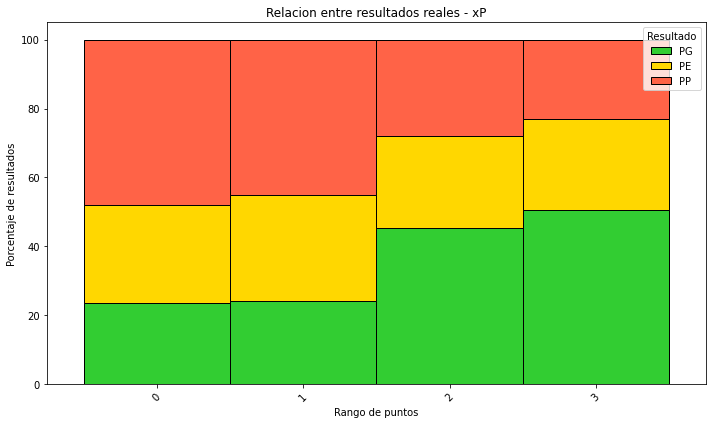

In [83]:
import matplotlib.pyplot as plt

custom_colors = [ '#32CD32','#FFD700', '#FF6347']  

ax = grouped_percentage.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=custom_colors,  
    width=1,  
    edgecolor='black' 
)

plt.title('Relacion entre resultados reales - xP')
plt.xlabel('Rango de puntos')
plt.ylabel('Porcentaje de resultados')
plt.legend(title='Resultado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

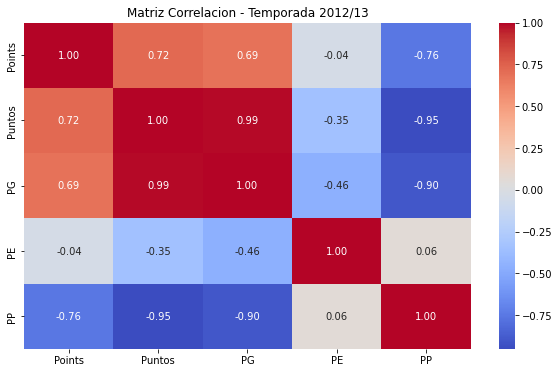

In [84]:
import seaborn as sns
correlation_matrix = final_ranking[['Points','Puntos', 'PG', 'PE', 'PP']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz Correlacion - Temporada 2012/13')
plt.show()

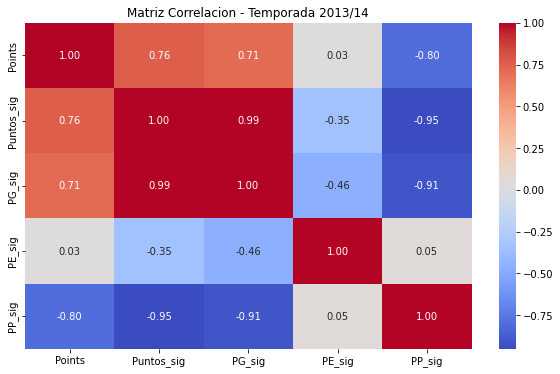

In [85]:
correlation_matrix_next = final_ranking[['Points', 'Puntos_sig','PG_sig', 'PE_sig', 'PP_sig']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_next, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz Correlacion - Temporada 2013/14')
plt.show()

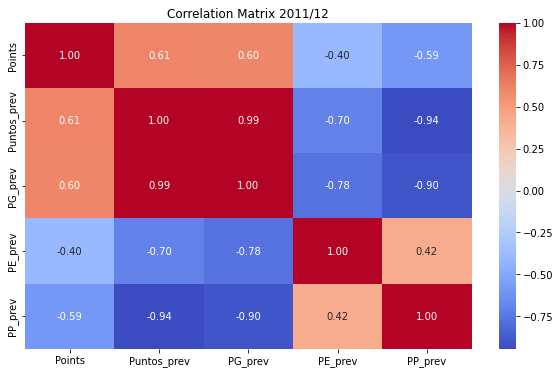

In [ ]:
correlation_matrix_prev = final_ranking[['Points', 'Puntos_prev','PG_prev', 'PE_prev', 'PP_prev']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_prev, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz Correlacion - Temporada 2011/12')
plt.show()

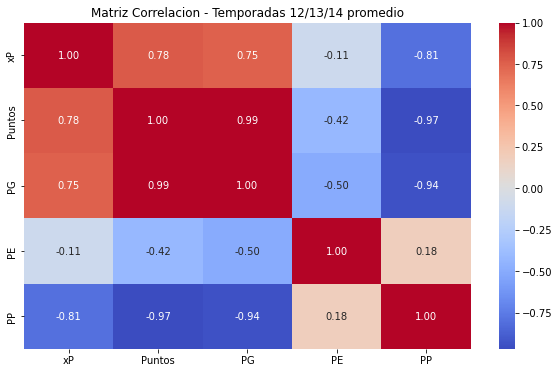

In [89]:
averaged_metrics = {
    'xP': final_ranking[['Points']].mean(axis=1, skipna=True),
    'Puntos': final_ranking[['Puntos', 'Puntos_sig']].mean(axis=1, skipna=True),
    'PG': final_ranking[['PG', 'PG_sig']].mean(axis=1, skipna=True),
    'PE': final_ranking[['PE', 'PE_sig']].mean(axis=1, skipna=True),
    'PP': final_ranking[['PP', 'PP_sig']].mean(axis=1, skipna=True),
}
averaged_df = pd.DataFrame(averaged_metrics)

correlation_matrix_avg = averaged_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_avg, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz Correlacion - Temporadas 12/13/14 promedio')
plt.show()


In [90]:
resultados_detallados = pd.read_csv('/Users/luisalawson/Desktop/PRUEBA_J_21_DISTRIBUCIONES.csv')

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_mc = resultados_detallados[(resultados_detallados['home'] == 'Manchester City') | 
                               (resultados_detallados['away'] == 'Manchester City')]
eventos = ['goles_local', 'goles_visitante', 'tiros_local', 'tiros_visitante', 
           'pases_local', 'pases_visitante', 'quites_local', 'quites_visitante']
df_eventos = df_mc[['home', 'away'] + eventos]
df_eventos.loc[:, 'goles'] = df_eventos.apply(lambda row: row['goles_local'] if row['home'] == 'Manchester City' else row['goles_visitante'], axis=1)
df_eventos.loc[:, 'tiros'] = df_eventos.apply(lambda row: row['tiros_local'] if row['home'] == 'Manchester City' else row['tiros_visitante'], axis=1)
df_eventos.loc[:, 'pases'] = df_eventos.apply(lambda row: row['pases_local'] if row['home'] == 'Manchester City' else row['pases_visitante'], axis=1)
df_eventos.loc[:, 'quites'] = df_eventos.apply(lambda row: row['quites_local'] if row['home'] == 'Manchester City' else row['quites_visitante'], axis=1)
eventos_dict = {'Goles': df_eventos['goles'], 'Tiros': df_eventos['tiros'], 
                'Pases': df_eventos['pases'], 'Quites': df_eventos['quites']}

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_63144/490934485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eventos.loc[:, 'goles'] = df_eventos.apply(lambda row: row['goles_local'] if row['home'] == 'Manchester City' else row['goles_visitante'], axis=1)
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_63144/490934485.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eventos.loc[:, 'tiros'] = df_eventos.apply(lambda row: row['tiros_local'] if row['home'] == 'Manchester

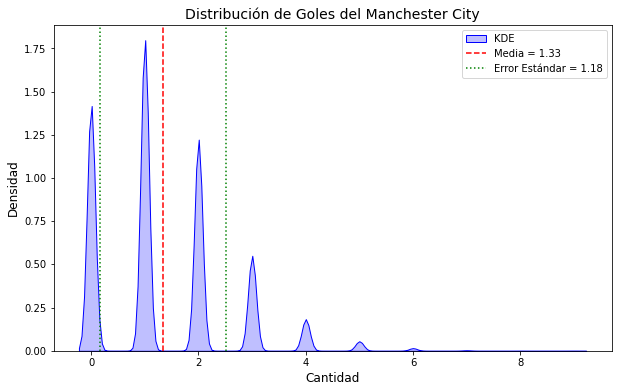

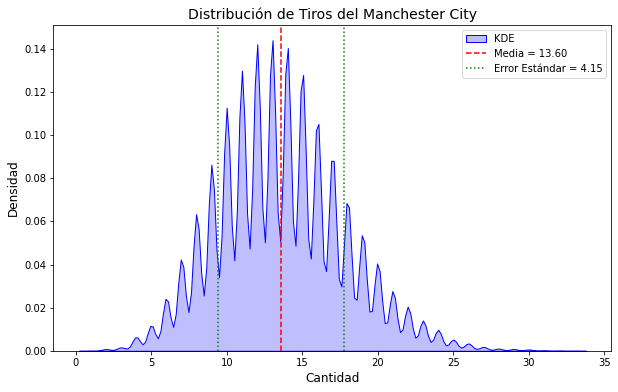

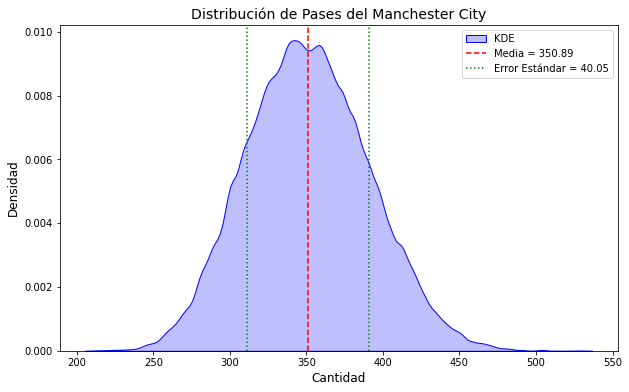

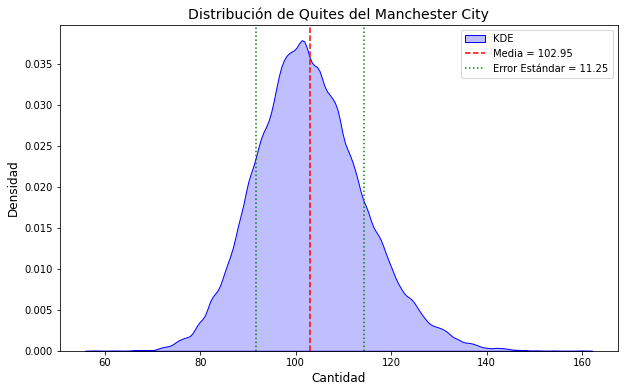

In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for evento, data in eventos_dict.items():
    media = np.mean(data)
    error_estandar = np.std(data)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(data, fill=True, bw_adjust=0.5, color="blue", label="KDE")
    
    plt.axvline(media, color='red', linestyle='--', label=f'Media = {media:.2f}')
    plt.axvline(media - error_estandar, color='green', linestyle=':', label=f'Error Estándar = {error_estandar:.2f}')
    plt.axvline(media + error_estandar, color='green', linestyle=':', label='_nolegend_')
    
    plt.title(f'Distribución de {evento} del Manchester City', fontsize=14)
    plt.xlabel('Cantidad', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.legend(loc='upper right')
    
    plt.show()


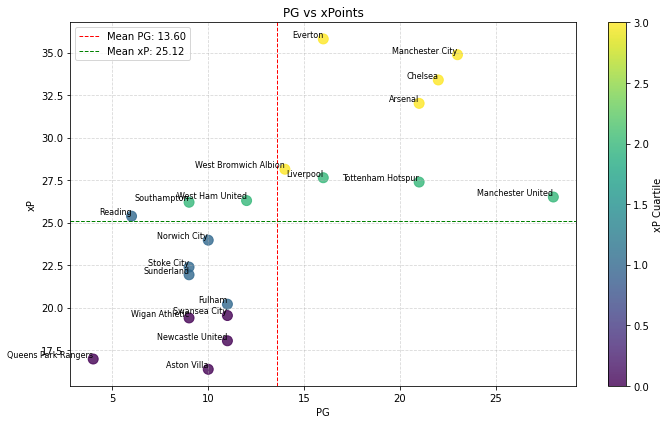

In [93]:
import matplotlib.pyplot as plt
import pandas as pd

mean_PG = final_ranking['PG'].mean()
mean_Points = final_ranking['Points'].mean()


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_ranking['PG'], 
    final_ranking['Points'], 
    c=final_ranking['Points_Quintile'], 
    cmap='viridis', 
    s=100, 
    alpha=0.8
)

for i, row in final_ranking.iterrows():
    plt.annotate(row['Team'], (row['PG'], row['Points']), fontsize=8, ha='right', va='bottom')

plt.axvline(mean_PG, color='red', linestyle='--', linewidth=1, label=f'Mean PG: {mean_PG:.2f}')
plt.axhline(mean_Points, color='green', linestyle='--', linewidth=1, label=f'Mean xP: {mean_Points:.2f}')

plt.xlabel('PG')
plt.ylabel('xP')
plt.title('PG vs xPoints')
plt.colorbar(scatter, label='xP Cuartile') 
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

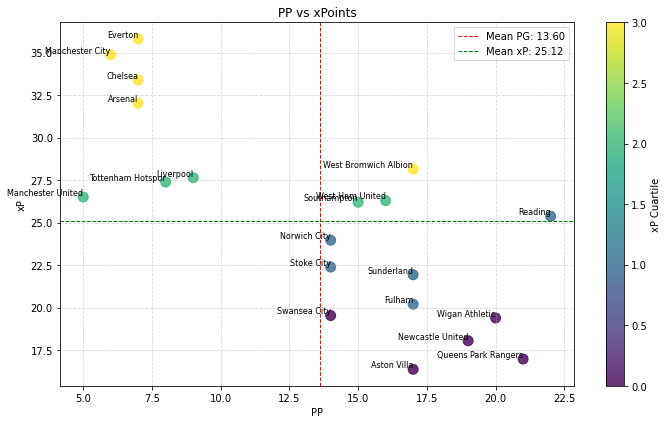

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

mean_PP = final_ranking['PP'].mean()
mean_Points = final_ranking['Points'].mean()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_ranking['PP'], 
    final_ranking['Points'], 
    c=final_ranking['Points_Quintile'], 
    cmap='viridis', 
    s=100, 
    alpha=0.8
)


for i, row in final_ranking.iterrows():
    plt.annotate(row['Team'], (row['PP'], row['Points']), fontsize=8, ha='right', va='bottom')

plt.axvline(mean_PP, color='red', linestyle='--', linewidth=1, label=f'Mean PG: {mean_PP:.2f}')
plt.axhline(mean_Points, color='green', linestyle='--', linewidth=1, label=f'Mean xP: {mean_Points:.2f}')

plt.xlabel('PP')
plt.ylabel('xP')
plt.title('PP vs xPoints')
plt.colorbar(scatter, label='xP Cuartile') 
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [95]:
final_ranking['real_position'] = final_ranking['real_position'].apply(lambda x: x - 1)

In [96]:
final_ranking

,Team,Points,real_position,Puntos,Puntos_sig,Puntos_prev,PG,PG_sig,PG_prev,PE,PE_sig,PE_prev,PP,PP_sig,PP_prev,Points_Quintile
0,Everton,35.808667,5,63,72.0,56.0,16,21.0,15.0,15,9.0,11.0,7,8.0,12.0,3
1,Manchester City,34.878667,1,78,86.0,89.0,23,27.0,28.0,9,5.0,5.0,6,6.0,5.0,3
2,Chelsea,33.393333,2,75,82.0,64.0,22,25.0,18.0,9,7.0,10.0,7,6.0,10.0,3
3,Arsenal,32.015333,3,73,79.0,70.0,21,24.0,21.0,10,7.0,7.0,7,7.0,10.0,3
4,West Bromwich Albion,28.138667,7,49,36.0,47.0,14,7.0,13.0,7,15.0,8.0,17,16.0,17.0,3
5,Liverpool,27.638667,6,61,84.0,52.0,16,26.0,14.0,13,6.0,10.0,9,6.0,14.0,2
6,Tottenham Hotspur,27.383333,4,72,69.0,69.0,21,21.0,20.0,9,6.0,9.0,8,11.0,9.0,2
7,Manchester United,26.502667,0,89,64.0,89.0,28,19.0,28.0,5,7.0,5.0,5,12.0,5.0,2
8,West Ham United,26.293333,9,46,40.0,NaN,12,11.0,NaN,10,7.0,NaN,16,20.0,NaN,2
9,Southampton,26.194667,13,41,56.0,NaN,9,15.0,NaN,14,11.0,NaN,15,12.0,NaN,2


## Simulamos con cambio de jugadores

In [999]:
def choose_teams(teams_list, players_data):
    """
    Permite al usuario elegir un equipo completo o un equipo personalizado.
    Devuelve un diccionario en el formato: {'TeamName': [(player1, periods), (player2, periods), ...]}.
    """
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores
    team_name = ""

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        # Selección de jugadores personalizados de diferentes equipos
        team_name = input("Ingresa el nombre del equipo personalizado: ")

        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1

            if 0 <= team_index < len(teams_list):
                team_origin = teams_list[team_index]
                available_players = [player for player in players_data[team_origin] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_origin}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        break
                    elif 0 <= player_index < len(available_players):
                        # Agregar el jugador al equipo de origen en `players_dict`
                        players_dict[team_origin].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a {team_origin}.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return team_name, players_dict

In [1000]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [1053]:
import pandas as pd
from collections import defaultdict

def simulate_against_all_teams(team_name, selected_team_players, teams_list, all_results):
    if 'Match' not in all_results.columns:
        all_results.reset_index(inplace=True)

    updated_results = all_results.copy()
    results = []

    for opponent_team in teams_list:
        if opponent_team == team_name:
            continue  

        team1 = team_name
        team2 = opponent_team
        team1_players = {team1: selected_team_players[team1]}
        team2_players = {team2: [(player, 'full_period') for player in get_initial_11(team2)]}

        match_result_df = simulate_matches(1000, team1_players, team2_players)
        
        match_result_df['winner'] = match_result_df.apply(
            lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                        row['away'] if row['goles_local'] < row['goles_visitante'] else
                        'tie', axis=1
        )

        total_games = match_result_df.shape[0]
        win_counts = match_result_df['winner'].value_counts()
        win_pct_team1 = (win_counts.get(team1, 0) / total_games) * 100
        win_pct_team2 = (win_counts.get(team2, 0) / total_games) * 100
        tie_pct = (win_counts.get('tie', 0) / total_games) * 100
        loss_pct_team1 = win_pct_team2  
        loss_pct_team2 = win_pct_team1

        new_index = ['win%', 'loss%', 'tie%', 'avg_goles', 'avg_tiros', 'avg_pases', 'avg_quites'] 
        teams_current = [team1, team2]
        df_transposed = pd.DataFrame(index=new_index, columns=teams_current)
        
        df_transposed.loc['win%', team1] = win_pct_team1
        df_transposed.loc['loss%', team1] = loss_pct_team1
        df_transposed.loc['tie%', team1] = tie_pct
        df_transposed.loc['win%', team2] = win_pct_team2
        df_transposed.loc['loss%', team2] = loss_pct_team2
        df_transposed.loc['tie%', team2] = tie_pct

        df_transposed.loc['avg_goles', team1] = match_result_df['goles_local'].mean()
        df_transposed.loc['avg_goles', team2] = match_result_df['goles_visitante'].mean()
        df_transposed.loc['avg_tiros', team1] = match_result_df['tiros_local'].mean()
        df_transposed.loc['avg_tiros', team2] = match_result_df['tiros_visitante'].mean()
        df_transposed.loc['avg_pases', team1] = match_result_df['pases_local'].mean()
        df_transposed.loc['avg_pases', team2] = match_result_df['pases_visitante'].mean()
        df_transposed.loc['avg_quites', team1] = match_result_df['quites_local'].mean()
        df_transposed.loc['avg_quites', team2] = match_result_df['quites_visitante'].mean()

        match_key1 = f"{team1} vs {team2}"
        match_key2 = f"{team2} vs {team1}"
        
        if match_key1 in updated_results['Match'].values:
            for metric in new_index:
                updated_results.loc[(updated_results['Match'] == match_key1) & 
                                    (updated_results['Unnamed: 1'] == metric), team1] = df_transposed.loc[metric, team1]
                updated_results.loc[(updated_results['Match'] == match_key1) & 
                                    (updated_results['Unnamed: 1'] == metric), team2] = df_transposed.loc[metric, team2]
                
        elif match_key2 in updated_results['Match'].values:
            for metric in new_index:
                updated_results.loc[(updated_results['Match'] == match_key2) & 
                                    (updated_results['Unnamed: 1'] == metric), team1] = df_transposed.loc[metric, team1]
                updated_results.loc[(updated_results['Match'] == match_key2) & 
                                    (updated_results['Unnamed: 1'] == metric), team2] = df_transposed.loc[metric, team2]
    return updated_results

In [1074]:
team_name, selected_team_players = choose_teams(teams_list, players_dict)
updated_all_results = simulate_against_all_teams(team_name, selected_team_players, teams_list, all_results)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Chelsea
4. Arsenal
5. Tottenham Hotspur
6. Everton
7. Liverpool
8. West Bromwich Albion
9. Swansea City
10. West Ham United
11. Norwich City
12. Fulham
13. Stoke City
14. Southampton
15. Aston Villa
16. Newcastle United
17. Sunderland
18. Wigan Athletic
19. Reading
20. Queens Park Rangers
Jugadores disponibles en Manchester City:
1. Hart, Joe
2. Aguero, Sergio
3. Toure, Gnegneri Yaya
4. Silva, David
5. Dzeko, Edin
6. Lescott, Joleon
7. Barry, Gareth
8. Nasri, Samir
9. Richards, Micah
10. Clichy, Gael
11. Kompany, Vincent
12. Tevez, Carlos
13. Zabaleta, Pablo
14. Kolarov, Aleksandar
15. Garcia Fernandez, Francisco Javier
16. Milner, James
17. Nastasic, Matija
18. Rodwell, Jack
19. Balotelli, Mario
20. Toure, Kolo
21. Sinclair, Scott
22. Maicon, Douglas
23. Razak, Abdul
24. Rekik, Karim
Jugador Hart, Joe ag

Simulando partidos: 100%|██████████| 1000/1000 [01:49<00:00,  9.12partido/s]


In [1148]:
real_ranking = pd.read_csv('/Users/luisalawson/Downloads/PRUEBA_J_21.csv')

## Impacto

In [1149]:
real_ranking.rename(columns={'Unnamed: 0': 'Match'}, inplace=True)  


In [1151]:
real_ranking.set_index('Match', inplace=True)  

In [1152]:
real_ranking

,Unnamed: 1,Manchester United,Manchester City,Chelsea,Arsenal,Tottenham Hotspur,Everton,Liverpool,West Bromwich Albion,Swansea City,...,Norwich City,Fulham,Stoke City,Southampton,Aston Villa,Newcastle United,Sunderland,Wigan Athletic,Reading,Queens Park Rangers
Match,,,,,,,,,,,,,,,,,,,,,
Manchester United vs Manchester City,win%,23.066667,53.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester United vs Manchester City,loss%,53.400000,23.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester United vs Manchester City,tie%,23.533333,23.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester United vs Manchester City,avg_goles,0.922667,1.594000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester United vs Manchester City,avg_tiros,9.506667,12.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Reading vs Queens Park Rangers,tie%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.066667,45.066667
Reading vs Queens Park Rangers,avg_goles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.649333,0.322667
Reading vs Queens Park Rangers,avg_tiros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.910000,9.810000


In [1153]:
RANKING = simulate_season_ranking(real_ranking)

In [1154]:
RANKING

,Team,Points
1,Everton,35.808667
2,Manchester City,34.878667
3,Chelsea,33.393333
4,Arsenal,32.015333
5,West Bromwich Albion,28.138667
6,Liverpool,27.638667
7,Tottenham Hotspur,27.383333
8,Manchester United,26.502667
9,West Ham United,26.293333
10,Southampton,26.194667


In [1170]:
PLAYER_TEST_IMPACT = ['AGUERO', 'TOURE','SILVA','DZEKO','LESCOTT','BARRY','NASRI','RICHARDS','KOMPANY', 'CLICHY']

In [1174]:
results = []

In [ ]:
results = []

for player in PLAYER_TEST_IMPACT:
    # Load player-specific data
    player_change_ranking_ = pd.read_csv(f'/Users/luisalawson/Downloads/PRUEBA_J_21_{player}.csv')
    player_change_ranking_.rename(columns={'Unnamed: 0': 'Match_'}, inplace=True)
    player_change_ranking_.drop('Match_', axis=1, inplace=True)
    player_change_ranking_.set_index('Match', inplace=True)
    
    # Simulate season rankings
    player_change_ranking = simulate_season_ranking(player_change_ranking_)
    
    # Get Manchester City points
    player_mc_points = player_change_ranking.loc[player_change_ranking['Team'] == 'Manchester City', 'Points']
    real_mc_points = RANKING.loc[RANKING['Team'] == 'Manchester City', 'Points']
    
    # Calculate percent change in points
    if not player_mc_points.empty and not real_mc_points.empty:
        player_mc_points_value = pd.to_numeric(player_mc_points.values[0], errors='coerce')
        real_mc_points_value = pd.to_numeric(real_mc_points.values[0], errors='coerce')
        if pd.notna(player_mc_points_value) and pd.notna(real_mc_points_value):
            percent_change = ((player_mc_points_value - real_mc_points_value) / real_mc_points_value) * 100
        else:
            percent_change = None
        results.append({'Player': player, '% Change in Points': percent_change})
    else:
        results.append({'Player': player, '% Change in Points': None})

# Create a DataFrame from results
results_df = pd.DataFrame(results)


In [1177]:
results_df['% Change in Points'] = results_df['% Change in Points'].round(1)


In [1181]:
results_df = results_df.sort_values(by='% Change in Points', ascending=True)

In [1182]:
results_df

,Player,% Change in Points
3,DZEKO,-22.3
7,RICHARDS,-5.4
9,CLICHY,-5.4
8,KOMPANY,-3.5
4,LESCOTT,-2.9
0,AGUERO,-1.4
2,SILVA,0.2
5,BARRY,1.3
1,TOURE,4.6
6,NASRI,5.1


## Validando el modelo

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_mc = resultados_detallados[(resultados_detallados['home'] == 'Manchester United') | 
                               (resultados_detallados['away'] == 'Manchester United')]
eventos = ['goles_local', 'goles_visitante', 'tiros_local', 'tiros_visitante', 
           'pases_local', 'pases_visitante', 'quites_local', 'quites_visitante']
df_eventos = df_mc[['home', 'away'] + eventos]
df_eventos.loc[:, 'goles'] = df_eventos.apply(lambda row: row['goles_local'] if row['home'] == 'Manchester United' else row['goles_visitante'], axis=1)
df_eventos.loc[:, 'tiros'] = df_eventos.apply(lambda row: row['tiros_local'] if row['home'] == 'Manchester United' else row['tiros_visitante'], axis=1)
df_eventos.loc[:, 'pases'] = df_eventos.apply(lambda row: row['pases_local'] if row['home'] == 'Manchester United' else row['pases_visitante'], axis=1)
df_eventos.loc[:, 'quites'] = df_eventos.apply(lambda row: row['quites_local'] if row['home'] == 'Manchester United' else row['quites_visitante'], axis=1)
eventos_dict = {'Goles': df_eventos['goles'], 'Tiros': df_eventos['tiros'], 
                'Pases': df_eventos['pases'], 'Quites': df_eventos['quites']}

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_63144/2903107327.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eventos.loc[:, 'goles'] = df_eventos.apply(lambda row: row['goles_local'] if row['home'] == 'Manchester United' else row['goles_visitante'], axis=1)
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_63144/2903107327.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eventos.loc[:, 'tiros'] = df_eventos.apply(lambda row: row['tiros_local'] if row['home'] == 'Manche

In [109]:
df_complete = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter =';')

In [110]:
df_complete['description'].value_counts()

description
Pass                            367734
Out                              48526
Ball recovery                    34529
Clearance                        26242
Aerial                           25228
Foul                             17124
Ball touch                       16773
Tackle                           14539
Take On                          11877
Interception                     11823
Deleted event                     9786
Dispossessed                      9073
Corner Awarded                    8478
Attempt Saved                     5254
Keeper pick-up                    5249
Save                              5210
Challenge                         5136
Miss                              4115
End                               2280
Player on                         2035
Player off                        2035
Offside provoked                  1736
Offside Pass                      1736
Start                             1520
Card                              1251
Start delay  

In [112]:
# Calcular el total de eventos en df_complete
total_events = len(df_complete)

# Calcular las proporciones basadas en las condiciones
successful_passes = df_complete[(df_complete['description'] == 'Pass') & (df_complete['outcome'] == 1)]
successful_interceptions = df_complete[
    (df_complete['description'].isin(['Interception', 'Tackle', 'Clearance', 'Aerial', 'Ball recovery', 'Offside Provoked'])) & 
    (df_complete['outcome'] == 1)
]
errors = df_complete[(df_complete['description'] == 'Error') & (df_complete['outcome'] == 1)]
shots_conditions = df_complete['description'].isin(['Attempt saved', 'Goal', 'Miss', 'Post'])
shots = df_complete[shots_conditions]
goals = df_complete[(df_complete['description'] == 'Goal') & (df_complete['outcome'] == 1)]
outs = df_complete[(df_complete['description'] == 'Out') & (df_complete['outcome'] == 0)]

# Calcular proporciones
proportions = {
    'Pases': len(successful_passes) / total_events,
    'Intercepciones': len(successful_interceptions) / total_events,
    'Errores': len(errors) / total_events,
    'Tiros al arco': len(shots) / total_events,
    'Goles': len(goals) / total_events,
    'Fuera de cancha': len(outs) / total_events
}

# Crear un DataFrame para visualizar las proporciones
import pandas as pd

proportions_df = pd.DataFrame.from_dict(proportions, orient='index', columns=['Proportion'])
proportions_df = proportions_df.sort_values(by='Proportion', ascending=False)

# Mostrar las proporciones
print(proportions_df)

                 Proportion
Pases              0.438463
Intercepciones     0.131159
Fuera de cancha    0.037347
Tiros al arco      0.008250
Goles              0.001638
Errores            0.000846


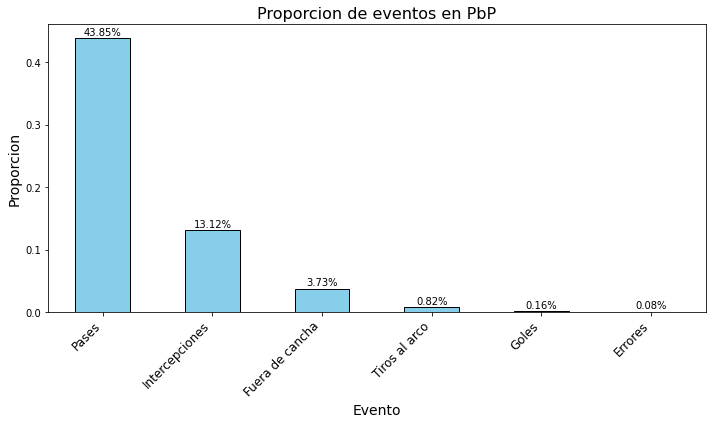

In [114]:
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
proportions_df['Proportion'].plot(kind='bar', color='skyblue', edgecolor='black')

# Agregar títulos y etiquetas
plt.title('Proporcion de eventos en PbP', fontsize=16)
plt.ylabel('Proporcion', fontsize=14)
plt.xlabel('Evento', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')

# Mostrar los valores sobre las barras
for index, value in enumerate(proportions_df['Proportion']):
    plt.text(index, value + 0.005, f'{value:.2%}', ha='center', fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [105]:
df_ManCity = df_complete[(df_complete['home_team_name'] == 'Manchester United') | 
                         (df_complete['away_team_name'] == 'Manchester United')]

In [106]:
df_ManCity_final = df_ManCity[df_ManCity['team_id']==1]

In [107]:
successful_passes = df_ManCity_final[(df_ManCity_final['description'] == 'Pass') & (df_ManCity_final['outcome'] == 1)]
failed_passes = df_ManCity_final[(df_ManCity_final['description'] == 'Pass') & (df_ManCity_final['outcome'] == 0)]
successful_interceptions = df_ManCity_final[
    (df_ManCity_final['description'].isin(['Interception', 'Tackle', 'Clearance', 'Aerial', 'Ball recovery', 'Offside Provoked'])) & 
    (df_ManCity_final['outcome'] == 1)
]
errors = df_ManCity_final[ ((df_ManCity_final['description'] == 'Error') & (df_ManCity_final['outcome'] == 1))
]

passes_count = successful_passes.groupby('match_id').size().rename('Successful passes')
passes_failed_count = failed_passes.groupby('match_id').size().rename('Unsuccessful passes')
interceptions_count = successful_interceptions.groupby('match_id').size().rename('Successful interceptions')
errors_count = errors.groupby('match_id').size().rename('Erors')

shots_conditions = df_ManCity_final['description'].isin(['Attempt saved', 'Goal', 'Miss', 'Post'])
shots = df_ManCity_final[shots_conditions]

shots_count = shots.groupby('match_id').size().rename('Shots')
goals = df_ManCity_final[(df_ManCity_final['description'] == 'Goal') & (df_ManCity_final['outcome'] == 1)]
goals_count = goals.groupby('match_id').size().rename('Goals')

outs = df_ManCity_final[(df_ManCity_final['description'] == 'Out') & (df_ManCity_final['outcome'] == 0)]
out_count = outs.groupby('match_id').size().rename('Goals')


df_ManCity_info = pd.DataFrame({
    'Successful passes': passes_count,
    'Unsuccessful passes': passes_failed_count,
    'Successful interceptions': interceptions_count,
    'Errors': errors_count,
    'Shots': shots_count,
    'Goals': goals_count,
    'Out': out_count
}).fillna(0).astype(int)  


In [ ]:
event_pairs = [
    ('Goles', 'Goals'),
    ('Tiros', 'Shots'),
    ('Pases', 'Successful passes'),
    ('Quites', 'Successful interceptions')
]

for real_event, simulated_event in event_pairs:
    plt.figure(figsize=(8, 5))
    
    sns.kdeplot(eventos_dict[real_event], shade=True, color='blue', label=f'Simulado: {real_event.capitalize()}', bw_adjust=5)
    
    sns.kdeplot(df_ManCity_info[simulated_event], shade=True, color='orange', label=f'Real: {real_event.capitalize()}', bw_adjust=1.5)
    
    real_mean = eventos_dict[real_event].mean()
    real_std = eventos_dict[real_event].std()
    simulated_mean = df_ManCity_info[simulated_event].mean()
    simulated_std = df_ManCity_info[simulated_event].std()
    
    plt.axvline(real_mean, color='blue', linestyle='--', label=f'Simulado Media: {real_mean:.2f}')
    plt.axvline(real_mean + real_std, color='green', linestyle='--', label=f'simulado +1 SD: {real_mean + real_std:.2f}')
    plt.axvline(real_mean - real_std, color='green', linestyle='--', label=f'simulado -1 SD: {real_mean - real_std:.2f}')
    
    plt.axvline(simulated_mean, color='orange', linestyle='--', label=f'real Mean: {simulated_mean:.2f}')
    plt.axvline(simulated_mean + simulated_std, color='red', linestyle='--', label=f'real +1 2: {simulated_mean + simulated_std:.2f}')
    plt.axvline(simulated_mean - simulated_std, color='red', linestyle='--', label=f'real -1 SD: {simulated_mean - simulated_std:.2f}')
    
    plt.title(f'Comparación eventos - Simulación vs Realidad (PL 2012/13)')
    plt.xlabel('Cantidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

## Test

In [ ]:
for team, players in players_dict.items():
    for player in players:
        shot_matrix, pass_matrix, goal_matrix, defense_matrix, out_balls = update_player_matrices(player, team, df_complete)
        shots = np.sum(shot_matrix)
        passes = np.sum(pass_matrix)
        goals = np.sum(goal_matrix)
        defense = np.sum(defense_matrix)
        out = np.sum(out_balls)

        real_passes = (df_complete[
        (df_complete['description'] == 'Pass') &
        (df_complete['outcome'] == 1) &
        (df_complete['playerName'] == player) &
        (0 <= pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round() < 100) &
        (0 <= pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round() < 100)
        ]).shape[0]

        real_shots = (df_complete[
        ((df_complete['description'] == 'Miss') | (df_complete['description'] == 'Post')) &
        (df_complete['playerName'] == player) &
        (0 <= pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round() < 100) &
        (0 <= pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round() < 100)
        ]).shape[0]

        real_goals = (df_complete[
        ((df_complete['description'] == 'Goal') | (df_complete['description'] == 'Attempt Saved')) & 
        (df_complete['playerName'] == player) &
        (0 <= pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round() < 100) &
        (0 <= pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round() < 100)
        ]).shape[0]

        real_outs = (df_complete[
        (df_complete['description'] == 'Out') &  (df_complete['outcome'] == 0) &
        (df_complete['playerName'] == player) &
        (0 <= pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round() < 100) &
        (0 <= pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round() < 100)
        ]).shape[0]

        real_interceptions = df_complete[
        (df_complete['description'].isin(['Interception', 'Tackle', 'Clearance', 'Aerial', 
                                        'Ball recovery', 'Offside provoked', 'Shield ball opp'])) & 
        (df_complete['outcome'] == 1) &
        (df_complete['playerName'] == player) &
        (0 <= pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['x'].str.replace(',', '.'), errors='coerce').round() < 100) &
        (0 <= pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round()) &
        (pd.to_numeric(df_complete['y'].str.replace(',', '.'), errors='coerce').round() < 100
        )].shape[0]

        if shots != real_shots:
            print(f"Mismatch for {player} in shots. Matrix shots: {shots}, Real Shots: {real_shots}")
        if passes != real_passes:
            print(f"Mismatch for {player} in passes. Matrix passes: {passes}, Real Passes: {real_passes}")
        if defense != real_interceptions:
            print(f"Mismatch for {player} in defense. Matrix defense: {defense}, Real defense: {real_interceptions}")
        if goals != real_goals:
            print(f"Mismatch for {player} in goals. Matrix goals: {goals}, Real goals: {real_goals}")
        
        print(f'Completado para el jugador {player}')
